In [1]:
import os

from os.path import  join, isdir
from plan import Plan
from action import Action
from utils import load_from_folder
from multiprocess import Pool
import random
from logging import exception
import re
import shutil

random.seed(42)

In [2]:
save_dir = './generated_gr_dataset/'
data_base_dir = '../datasets/'
domain = 'logistics'
results_dir = f"{save_dir}/{domain}/"   
source_dir = f"{join(data_base_dir, domain)}/optimal_plans/dictionaries_and_plans/" 
print('Domain dir:', source_dir)
os.makedirs(save_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

plans_to_process = 10000 # number of plans to process
versions_per_plan = 5 # number of versions per each plan
number_of_goals = 4 # number of goals per each new plan
test = False # test will process only 3 plans
#rec_classes = [[0,0.2], [0.2,0.3], [0.3,0.4], [0.4,0.5], [0.5,0.6], [0.6,0.7], [0.7,0.8], [0.8,0.999]] # classes of recognizability
rec_classes = [[0,0.2], [0.2,0.4], [0.4,0.6], [0.6,0.8], [0.8, 1]] # classes of recognizability

Domain dir: ../datasets/logistics/optimal_plans/dictionaries_and_plans/


In [29]:
#to clear the results directory
for folder in os.listdir(results_dir):
    #remove directory if it exists along with its content
    if isdir(join(results_dir, folder)):
        shutil.rmtree(join(results_dir, folder))

In [4]:
#loading the plans
plans = load_from_folder(source_dir,["plans"])[0]
print(f"Plans: {len(plans)}")

plans loaded from ../datasets/logistics/optimal_plans/dictionaries_and_plans/
Plans: 47769


In [5]:
def compute_recognizability(current_goal_state, goal_state_list):
    """
    Compute the difficulty of a plan.
    :param current_goal_state: The goal state for which we calculate the recognizability.
    :param goal_state_list: The list of goal states to use for the computation.
    :return: The recognizability of the plan.
    """
    
    #the current goal state must be in the goal state list
    if current_goal_state not in goal_state_list:
        raise ValueError(f"current_goal_state {current_goal_state} must be included in goal_state_list {goal_state_list}")
    
    #min and max to use for normalization
    #teoretical min recognizability is when all the fluent in current are present in each goal state in the goal state list
    #the formula becomes 1/n+1/n+1/n+...+1/n = len(current_goal_state) / len(goal_state_list)
    #teoretical max recognizability is when all the fluent in current are not present anywhere in the goal state list
    #formula is 1/1 + 1/1 + 1/1 ... + 1/1 = 1 * len(current_goal_state)
    
    #? min max accettabili ovvero
    #?  per il min almeno uno deve essere diverso, non vogliamo rec=0 , ok) 
    #?  per il max invece?   
    #?       è accettabile avere tutti i fluenti diversi quindi rec=1, o deve essercene uno in uno dei goal delle versioni che è uguale?
    
    min_recognizability = 1/(len(goal_state_list)) * (len(current_goal_state)) # tutti i fluenti uguali
    #min è quando sono tutti diversi di almeno uno
    #min_recognizability  = 1/(len(goal_state_list)) * (len(current_goal_state)-1) + 1/(len(goal_state_list)-1) # tutti fluenti presenti in tutti i goal a parte uno che non è presente da qualche parte
    #? (len(current_goal_state)-2) * (len(goal_state_list)+1)/len(goal_state_list) # questa è invece la tua formula per la massima uniqueness
    #? perchè la massima uniqueness non è quando i fluenti del base non compaiono da nessun'altra parte? o se quel caso non va bene allora quello in cui ce n'è solo uno uguale?
    max_recognizability  = 1*len(current_goal_state) # tutti fluenti diversi
    #max_recognizability  = 1*(len(current_goal_state)-1) + 1/2 # tutti fluenti diversi a parte uno che ha un doppione da qualche parte
    
    #todo sistemare formula hardcodando max e min
    #k=2, n=6 = 7/12 
    #k=3, n=6 = 3/4
    #k=4, n=6 = #da runnare
    #todo
    
    # print(f"min_recognizability: {min_recognizability}")
    # print(f"max_recognizability: {max_recognizability}")
    
    sum = 0
    
    # too see the sum of fractions
    # debug_string = ""
    #need to count how many times the current goal fluent is in the goal state list
    for current_goal_fluent in current_goal_state:
        count = 0
        for goal_state in goal_state_list:
            for goal_fluent in goal_state:       
                if current_goal_fluent==goal_fluent:
                    count += 1
                    break
        sum += 1/count
    #     debug_string += f" + 1/{count}"
    
    # debug_string += f" = {sum}"
    # debug_string = debug_string[3:]
    #print(f"Unscaled recognizability: {sum}")
    
    #normalize the recognizability #? should be ok 
    recognizability = (sum-min_recognizability) / (max_recognizability-min_recognizability)
    # print(debug_string)
    return round(recognizability, 4)
                    

In [6]:
# your paper example

# If G={G1,G2,G3},  with G∗=
# G1={a,b,c}, 
# G2={a,e,f}, 
# G3={g,h,i}, 
# then R(G∗) = 1/2+ 1 + 1 = 5/2 and Rz(G∗) = 0.75(high recognizability). 

# If G={G1,G2,G3}, with G∗=
# G1={a,b,c},
# G2={a,b,x},
# G3={a,b,y}, 
# then R(G∗) =1/3+1/3+ 1 =5/3, and so Rz(G∗) = 0.33(low recognizability).

#se uso i massimi e minimi teoretici che ho usato fino ad adesso esce giusto, con le altre formule non mi torna
    #min_recognizability = 1/(len(goal_state_list)) * (len(current_goal_state)) # tutti i fluenti uguali
    #max_recognizability  = 1*len(current_goal_state) # tutti fluenti diversi


#test compute_recognizability
goal_state_list = [["a", "b", "c"], 
                   ["a", "e", "f"], 
                   ["g", "h", "i"],]
print(compute_recognizability(goal_state_list[0], goal_state_list))

goal_state_list = [["a", "b", "c"], 
                   ["a", "b", "x"], 
                   ["a", "b", "y"],]
print(compute_recognizability(goal_state_list[0], goal_state_list))

0.75
0.3333


In [7]:
 #todo subject to change depending on how we want output
def write_and_save_versions(plan, goal_state_list, obj_set_dict={}, rec_class=[0,1]):
    """Write the plan and its versions to files.
    :param plan: The plan to write.
    :param goal_state_list: The list of goal states, each state will produce a different version, at index 0 should be the original plan.
    :param obj_set_dict: The dictionary of objects.
    :return: None
    """
        
    for i, goal_state in enumerate(goal_state_list):
        
        #extract plan name with regex
        name = re.search(r"(p\d+)(?=\.)", plan.plan_name).group(1)
        
        #definition
        new_problem = ""
        # if i==0:
        #     new_problem += f";;(;metadata (recognizability:{round(compute_recognizability(goal_state_list[0], goal_state_list),2)})\n"
        
        new_problem += f"(define (problem {domain}_{name}_{i})\n(:domain {domain})\n(:objects\n\t"
    
        
        #objects in a dict format, {type: obj_set}
        for type, obj_set in obj_set_dict.items():
            if len(obj_set) > 0:
                for obj in obj_set:
                    new_problem += f"{obj} "
                new_problem += f"- {type}\n\t"
        new_problem += f")\n"
        
        #initial state
        new_problem += f"(:init\n"
        for fluent in plan.initial_state:
            new_problem += f"\t{fluent}\n"
        new_problem += f")\n"
        
        #goal state
        new_problem += f"(:goal (and\n"
        for goal in goal_state:
            new_problem += f"\t{goal}\n"
        new_problem += f"))\n)"
        #print(new_problem + "\n\n")
        
        #save the new problem in a file
        #naming convention is {current plan name_version number.pddl}, _0 is the original plan
        new_problem_dir = f"{results_dir}/{name}/"
        class_dir = f"{results_dir}/{name}/{rec_class[0]}_{rec_class[1]}/"
        os.makedirs(new_problem_dir, exist_ok=True)
        os.makedirs(class_dir, exist_ok=True)
        new_problem_file = f"{class_dir}/{name}_{i}.pddl"
        with open(new_problem_file, "w") as f:
            f.write(new_problem)

In [8]:
 #todo subject to change depending on how we want output

def write_original_plan(plan, goal_state, obj_set_dict):
    
    #extract plan name with regex
    name = re.search(r"(p\d+)(?=\.)", plan.plan_name).group(1)
    
    #definition
    new_problem = ""
    
    new_problem += f"(define (problem {domain}_{name}_og)\n(:domain {domain})\n(:objects\n\t"

    
    #objects in a dict format, {type: obj_set}
    for type, obj_set in obj_set_dict.items():
        if len(obj_set) > 0:
            for obj in obj_set:
                new_problem += f"{obj} "
            new_problem += f"- {type}\n\t"
    new_problem += f")\n"
    
    #initial state
    new_problem += f"(:init\n"
    for fluent in plan.initial_state:
        new_problem += f"\t{fluent}\n"
    new_problem += f")\n"
    
    #goal state
    new_problem += f"(:goal (and\n"
    for goal in goal_state:
        new_problem += f"\t{goal}\n"
    new_problem += f"))\n)"
    #print(new_problem + "\n\n")
    
    #save the new problem in a file
    #naming convention is {current plan name_version number.pddl}
    new_problem_dir = f"{results_dir}/{name}/"
    os.makedirs(new_problem_dir, exist_ok=True)
    new_problem_file = f"{new_problem_dir}/{name}_og.pddl"
    with open(new_problem_file, "w") as f:
        f.write(new_problem)

In [9]:

def check_if_goal_state_in_init(init, goal_state):
    goal_present_in_init = True
    for goal_fluent in goal_state:
        # print(base_goal_fluent)
        # print(problem.og_plan.initial_state)
        if goal_fluent in init:
            continue
        else:
            goal_present_in_init = False
            break
    
    return goal_present_in_init

def create_goal_state_list(initial_state, package_for_goal_set, pos_for_goal_set, number_of_goals, versions_per_plan):
    """Create a list of goal states.
    :param package_for_goal_set: The set of packages to use for the goal state.
    :param pos_for_goal_set: The set of positions to use for the goal state.
    :param number_of_goals: The number of goals to generate.
    :param versions_per_plan: The number of versions to generate.
    :return: A list of goal states.
    """	
    goal_state_list = []
    for i in range(0, versions_per_plan + 1):
        # generate a random goal state
        goal_state = generate_goal_state(initial_state, package_for_goal_set, pos_for_goal_set, number_of_goals)
            
        goal_state_list.append(goal_state)
        
    return goal_state_list
        
def generate_goal_state(initial_state, package_for_goal_set, pos_for_goal_set, number_of_goals):
    """Generate a random goal state.	
    :param package_for_goal_set: The set of packages to use for the goal state.
    :param pos_for_goal_set: The set of positions to use for the goal state.
    :param number_of_goals: The number of fluents to generate for the goal state.
    :return: A set of fluents representing a goal state.
    """
    while True:
        goal_state = set()
        package_for_goal_set_copy = package_for_goal_set.copy()
        pos_for_goal_set_copy = pos_for_goal_set.copy()
        for _ in range(number_of_goals):
            random_package = random.choice(list(package_for_goal_set_copy))
            package_for_goal_set_copy.remove(random_package)
            random_pos = random.choice(list(pos_for_goal_set_copy))
            
            #? can objects be in same position? assuming yes
            #? pos_for_goal_set_copy.remove(random_pos) 
            goal_state.add(f"at {random_package} {random_pos}") 
        
        if not check_if_goal_state_in_init(initial_state, goal_state):
            break
    return list(goal_state) 

In [10]:
#to calculate how precise the generation is
global_counter = 0

running_sum_rec_error = 0

In [11]:
def check_consistency(goal_state, prefix="obj"):
    """	
    Check if the goal state is consistent by checking if it has same obj used more than once.
    :param goal_state: The goal state to check.
    :return: True if the goal state is consistent, False otherwise.
    """
    objects = []
    for fluent in goal_state:
        obj = re.search(rf"{prefix}\d+", fluent)
        objects.append(obj.group(0))
    return len(objects) == len(set(objects))
        

def check_if_fluent_is_usable(fluent_to_add, goal_state):
    """
    Check if the fluent to add is usable in the goal state.
    This means checking if fluent is not already in the goal state and if the object in fluent is not already in the goal state.
    :param fluent_to_add: The fluent to add.
    :param goal_state: The goal state to check.
    :return: True if the fluent to add is usable, False otherwise.
    """
    #check if goal state is a list of strings
    if isinstance(fluent_to_add, list):
        raise ValueError(f"fluent to add is a list: {fluent_to_add}")
    for fluent in goal_state:
        if fluent == fluent_to_add:
            return False
        elif check_same_object_in_fluents(fluent_to_add, fluent, prefix="obj"):
            return False
    return True

def check_same_object_in_fluents(fluent1, fluent2, prefix="obj"):
    """
    Check if the object in fluent1 is in fluent2.
    :return: True if the object in fluent1 is in fluent2, False otherwise.
    """
    #extract the object from the fluent using regex
    obj1 = re.search(rf"{prefix}\d+", fluent1).group(0)
    obj2 = re.search(rf"{prefix}\d+", fluent2).group(0)

    if obj1 == obj2:
        return True
    return False

def check_duplicates(goal_state_list):
    """
    Check if the goal state list has duplicates.
    :param goal_state_list: The goal state list to check.
    :return: True if the goal state list has duplicates, False otherwise.
    """
    #check if goal state is a list of strings
    if isinstance(goal_state_list, str):
        raise ValueError(f"goal state list is a string: {goal_state_list}")
    
    #check if there are duplicates in the goal state list
    return len(goal_state_list) != len(set(tuple(sorted(g)) for g in goal_state_list))

def expand_candidates_list(goal_state, base_goal_state, package_for_goal_set, pos_for_goal_set):
    """
    Expand candidates list by generating all possible fluent
    """
    #generate all possible fluents
    all_possible_fluents = []
    for package in package_for_goal_set:
        for pos in pos_for_goal_set:
            all_possible_fluents.append(f"at {package} {pos}")
    
    #remove the fluents that are already in the goal state
    for fluent in goal_state:
        if fluent in all_possible_fluents:
            all_possible_fluents.remove(fluent)
    
    #remove the fluents that are already in the base goal state
    for fluent in base_goal_state:
        if fluent in all_possible_fluents:
            all_possible_fluents.remove(fluent)
            
    for fluent in all_possible_fluents:
        if not check_if_fluent_is_usable(fluent, goal_state):
            all_possible_fluents.remove(fluent)
    
    return all_possible_fluents

def adapt_goal_state_list_to_recognizability(initial_state, base_goal_state, goal_state_list, 
                                             package_for_goal_set, pos_for_goal_set, 
                                             number_of_goals, rec_target=[0, 1], 
                                             randomness_patience=5, regeneration_patience=3):
    """
    Adapt the goal state list to the recognizability. 
    This is done by swapping fluents between the base goal state and the goal state list.
    If we have to reduce recognisability, we swap a random fluent in the goal state list with a fluent from the base goal state.
    If we have to increase recognisability, we swap a fluent that is in the base goal state and in also in a goal in goal state list with a random possible fluent.
    This does not guarantee that the recognizability will be in the target range, but it will be close.
    It can happen that a goal state will be stuck in a local minimum, so we regenerate it to try staring from another point.
    We keep track of which regenerations we have done and if we reach the patience limit, we will use the one that is closest to the target recognizability.
    :param base_goal_state: The base goal state.
    :param goal_state_list: The list of goal states to use to compute recognizability, without base goal state.
    :param randomness_patience: The number of times we can try to adapt the goal state list before regenerating it. This will usually exhaust if we have many states that are stuck in a local minimum. If we reach this limit, we will regenerate the next stuck goal state.
    :param regeneration_patience: The number of times we can regenerate a goal state before giving up.
    :param package_for_goal_set: The set of packages to use for the goal state.
    :param pos_for_goal_set: The set of positions to use for the goal state.
    :param number_of_goals: The number of goals to generate.
    :param rec_target: The target range of recognizability.
    :return: The adapted goal state list.
    """
    
    if rec_target[0] > rec_target[1]:
        raise ValueError(f"rec_target[0] {rec_target[0]} must be less than rec_target[1] {rec_target[1]}")
    
    #variables to keep track of errors
    global global_counter
    global running_sum_rec_error
    
    
    randomness_patience_constant = randomness_patience
    
    #to keep track of the goal states that we have regenerated
    goal_regeneration_dict = {}
    
    #we identify all the fluents that are in the goal state list    
    all_goal_fluents = []
    for goal_state in goal_state_list:
        for fluent in goal_state:
            if fluent not in all_goal_fluents:
                all_goal_fluents.append(fluent)
    
    #we identify all the fluents that are not in the base goal state but are in the goal state list
    non_base_goal_fluents = []
    for fluent in all_goal_fluents:
        if fluent not in base_goal_state:
            non_base_goal_fluents.append(fluent)
    
    #starting recognizability
    running_recognizability = compute_recognizability(base_goal_state, [base_goal_state] + goal_state_list)
    #print(f"Starting recognizability: {running_recognizability}, range is {recognizability}")
    
    #while the recognizability is not in the target range, we will keep adapting the goal state list
    while running_recognizability < rec_target[0] or running_recognizability > rec_target[1]:
        #print(f"Running recognizability start of step: {running_recognizability}, range is {rec_target}")
        
        #choose a random goal state from the list
        goal_state = random.choice(goal_state_list)
        
        if running_recognizability > rec_target[1]:
            #rec too high: find a goal state in goal_state_list that has a fluent that is not in the base goal state
            #swap it with one from base_goal_fluents                
            
            #builds list of fluents that are in the base goal state but not in this goal state and don't introduce inconsistencies
            usable_base_goal_fluents = []
            for fluent in base_goal_state:  
                if check_if_fluent_is_usable(fluent, goal_state):
                    usable_base_goal_fluents.append(fluent)
                            
            if len(usable_base_goal_fluents) > 0:                
                
                #builds list of fluents that are in the goal state but not in the base goal state
                candidates_list = []
                for fluent in goal_state:
                    if fluent not in base_goal_state:
                        candidates_list.append(fluent)
                
                fluent_from_base_goal = random.choice(usable_base_goal_fluents)
                
                store_candidates_list = candidates_list.copy()
                
                #if there is at least one fluent to swap   
                if len(candidates_list) > 0:
                    
                    #we will do a while sequence to find a swap that does not introduce inconsistencies, creates duplicates or is already satisfied in the initial state
                    while True:
                        
                        # debug_goal_state = goal_state.copy() #debug
                        
                        if len(candidates_list) > 0:
                            random_fluent = random.choice(candidates_list)
                        else:
                            break
                        
                        # before = check_consistency(goal_state) #debug
                        
                        #we create what the state list will look like after the swap
                        proposed_goal_state = goal_state.copy()
                        proposed_goal_state_list = goal_state_list.copy()
                        proposed_goal_state_list[proposed_goal_state_list.index(goal_state)] = proposed_goal_state
                        
                        proposed_goal_state[proposed_goal_state.index(random_fluent)] = fluent_from_base_goal
                        
                        #then check if it's ok
                        if not check_duplicates(proposed_goal_state_list) and not check_if_goal_state_in_init(initial_state, proposed_goal_state):
                            break
                        else:
                            #if it's not we cannot use this candidate with this fluent
                            candidates_list.remove(random_fluent)
                            if len(candidates_list) == 0:
                                #if we finish the candidates we reset the list and try another usable fluent
                                candidates_list = store_candidates_list.copy()
                                usable_base_goal_fluents.remove(fluent_from_base_goal)
                                if len(usable_base_goal_fluents) == 0:
                                    #print(f"Candidate list is empty because of duplicates, no fluent from base goal is applicable breaking") # debug
                                    break
                                else:
                                    fluent_from_base_goal = random.choice(usable_base_goal_fluents)
                    
                    #if all is fine we make the swap in the list                             
                    goal_state_list[goal_state_list.index(goal_state)] = proposed_goal_state 
                    # after = check_consistency(goal_state) #debug
                    # if before == True and after == False: #debug
                    #     print(f"|>|Goal state is not consistent: old goal state{debug_goal_state}\n\t base_goal_state: {base_goal_state},\n\t fluent_to_swap: {fluent_to_swap},\n\t random_fluent: {random_fluent}, \n\t usable_base_goal_fluents: {usable_base_goal_fluents}\n\n") #debug
                                    
        elif running_recognizability < rec_target[0]:
            #rec too low: choose a goal state that has a fluent from base goal and swap it with a random one
            
            #builds list of fluents that are in the base goal state and also in this goal state
            present_base_goal_fluents = []
            for fluent in base_goal_state:
                if fluent in goal_state:
                    present_base_goal_fluents.append(fluent)
            
            #if there is at least one fluent to swap                    
            if len(present_base_goal_fluents) > 0:
                
                #builds list of fluents that are in the goal state but not in the base goal state, and don't introduce inconsistencies
                # candidates_list = []
                # for fluent in non_base_goal_fluents:
                #     if check_if_fluent_is_usable(fluent, goal_state):
                #         candidates_list.append(fluent)
                
                #build list of possible fluents to use in the swap
                candidates_list = expand_candidates_list(goal_state, base_goal_state, package_for_goal_set, pos_for_goal_set)
                
                #if there is at least one fluent to swap
                if len(candidates_list) > 0:
                    
                    #we will do a while sequence to find a swap that does not introduce inconsistencies, creates duplicates or is already satisfied in the initial state
                    while True:
                        random_fluent = random.choice(candidates_list)

                        fluent_to_swap = random.choice(present_base_goal_fluents)
                        
                        #we create what the state list will look like after the swap
                        proposed_goal_state = goal_state.copy()
                        proposed_goal_state_list = goal_state_list.copy()
                        proposed_goal_state_list[proposed_goal_state_list.index(goal_state)] = proposed_goal_state
                        
                        proposed_goal_state[proposed_goal_state.index(fluent_to_swap)] = random_fluent
                        
                        #then check if it's ok
                        if not check_duplicates(proposed_goal_state_list) and not check_if_goal_state_in_init(initial_state, proposed_goal_state):
                            break
                        else:
                            #if it's not we try another candidate
                            candidates_list.remove(random_fluent)
                            if len(candidates_list) == 0:
                                #print(f"Candidate list is empty because of duplicates, breaking") # debug
                                break
                        #todo some method to expand canditates list if it is empty, will probably need to generate all possible fluents
                        
                    # before = check_consistency(goal_state) #debug
                    
                    #we apply the swap
                    goal_state_list[goal_state_list.index(goal_state)] = proposed_goal_state
                    # after = check_consistency(goal_state) #debug
                    # if before == True and after == False: #debug
                    #     print(f"|<| Goal state is not consistent: {goal_state}\n\t base_goal_state: {base_goal_state},\n\t fluent_to_swap: {fluent_to_swap},\n\t random_fluent: {random_fluent}\n\n") #debug
                    
        #compute the recognizability after the step
        new_recognizability = compute_recognizability(base_goal_state, [base_goal_state] + goal_state_list)
        # Store the regeneration (the key is the recognizability of the prevoius configuration)
        goal_regeneration_dict[running_recognizability] = goal_state_list.copy()
        #if we have not changed the recognizability, the randomness patience is reduced
        #we will try another random goal state in the next iteration 
        if new_recognizability == running_recognizability:
            randomness_patience -= 1
            
            #if we have hit too many times stuck goal states, we will regenerate the last we encountered, so the one in this iteration
            if randomness_patience == 0 and regeneration_patience > 0:
                # Patience reached: regenerate stuck goal_state
                regeneration_patience -= 1
                randomness_patience = randomness_patience_constant
                

                #todo some way to make this not use patience and not loop forever without doing all possible combinations?s
                duplicate_patience = 10
                while duplicate_patience > 0:
                    new_goal_state = generate_goal_state(initial_state, package_for_goal_set, pos_for_goal_set, number_of_goals)
                    
                    proposed_goal_state_list = goal_state_list.copy()
                    proposed_goal_state_list[proposed_goal_state_list.index(goal_state)] = new_goal_state
                    if not check_duplicates(proposed_goal_state_list):
                        break
                    else:
                        duplicate_patience -= 1
                        if duplicate_patience == 0:
                            #print(f"Duplicate patience exhausted, breaking") # debug
                            break
            
                # Replace the goal state in the list with a new one
                goal_state = new_goal_state
            
            #if we have exhausted the regeneration patience, we will stop trying and take the best configuration we have
            elif randomness_patience == 0 and regeneration_patience == 0:
                # Patience exhausted; if we have any regenerations, choose the one with recognizability closest to target.
                if goal_regeneration_dict:
                    # Find the closest recognizability to the target
                    # must use midpoint as we could heve rec_scores both above and below the target
                    target_recognizability = (rec_target[0] + rec_target[1]) / 2 
                    
                    #? if we need to restrict certain type of rec implement these lines
                    # while True:
                    #     closest_recognizability = min(goal_regeneration_dict.keys(), key=lambda x: abs(x - target_recognizability))
                    #     #we do not want any problem with rec == 1 or 0, hard coded not to accept 
                    #     if closest_recognizability == 1 or closest_recognizability == 0:
                    #         goal_regeneration_dict.pop(closest_recognizability)
                    #     else:
                    #         break
                    #? else use only this
                    closest_recognizability = min(goal_regeneration_dict.keys(), key=lambda x: abs(x - target_recognizability))
                    #?
                    
                    running_recognizability = closest_recognizability
                    goal_state_list = goal_regeneration_dict[closest_recognizability]
                #print(f"Patience exhausted, breaking: Best recognizability: {running_recognizability} | Target: {rec_target}") # debug

                # to keep track of errors we do the distace to the target range
                error = abs(running_recognizability - rec_target[0]) if running_recognizability < rec_target[0] else abs(running_recognizability - rec_target[1])
                running_sum_rec_error += error
                global_counter += 1
                break
        #print(f"Running recognizability at end of step: {running_recognizability}")
        running_recognizability = new_recognizability
    return base_goal_state, goal_state_list

In [12]:
class GRProblem:
    def __init__(self, name, base_plan, obj_set_dict, base_goal_state, goal_state_list, rec, rec_class=[0,1]):
        
        self.name = name
        self.og_plan = base_plan
        self.problem_name = name
        # self.actions = base_plan.actions # we don't need as they are the old ones
        self.objects = obj_set_dict
        self.initial_state = base_plan.initial_state
        self.base_goal_state = base_goal_state
        self.goal_state_list = goal_state_list
        self.recognizability_class = rec_class
        self.recognizability = rec
    
    def __str__(self):
        description = f"Problem: {self.problem_name}, \n\tGoals: {self.base_goal_state}, \n\t"
        for i, goal_state in enumerate(self.goal_state_list):
            description += f"Goal state {i}: {goal_state}, \n\t"
        description += f"Recognizability: {self.recognizability}, Class: {self.recognizability_class}"

        return description
    

In [13]:
#test check_duplicates
# goal_state_list = [["a", "b"], 
#                    ["a", "b"], 
#                    ["g", "h"],
#                    ["f", "i"],
#                    ["a", "b", "c"],]

# print(check_duplicates(goal_state_list))

In [14]:
def generate_dataset(plans, versions_per_plan, rec_classes):
    gr_problems_list = []
    #duplicate_couter = 0
    count = 0
    for plan in plans:
        if test:
            if count >= 3:
                break
        elif count > plans_to_process:
            break
        #begin plan processing
        
        number_of_goals = len(plan.goals)
        
        all_obj_set = set()
        package_for_goal_set = set()
        pos_for_goal_set = set()
        
        #* find all objects in the initial state and actions
        for line in plan.initial_state:
            for obj in line.split(" ")[1:]:
                all_obj_set.add(obj)
        for action in plan.actions:
            for fluent in action.positiveEffects:
                for obj in fluent.split(" ")[1:]:
                    all_obj_set.add(obj)
            for fluent in action.negativeEffects:
                for obj in fluent.split(" ")[1:]:
                    all_obj_set.add(obj)
            for fluent in action.precondition:
                for obj in fluent.split(" ")[1:]:
                    all_obj_set.add(obj)
        
        #split the objects in their types
        pos_set = set()
        apn_set = set()
        cit_set = set()
        apt_set = set()
        tru_set = set()
        pack_set = set()
        obj_set_dict = {}
        for obj in all_obj_set:
            if obj.startswith("pos"):
                pos_set.add(obj)
                pos_for_goal_set.add(obj) #these will be used for goal creation
            elif obj.startswith("obj"):
                pack_set.add(obj)
                package_for_goal_set.add(obj) #these will be used for goal creation
            elif obj.startswith("apn"):
                apn_set.add(obj)
            elif obj.startswith("cit"):
                cit_set.add(obj)
            elif obj.startswith("tru"):
                tru_set.add(obj)
            elif obj.startswith("apt"):
                apt_set.add(obj)
        
        #useful for printing the plan
        if len(pos_set) > 0:
            obj_set_dict["location"] = pos_set
        if len(apn_set) > 0:
            obj_set_dict["airplane"] = apn_set
        if len(cit_set) > 0:
            obj_set_dict["city"] = cit_set
        if len(apt_set) > 0:
            obj_set_dict["airport"] = apt_set
        if len(tru_set) > 0:
            obj_set_dict["truck"] = tru_set
        if len(pack_set) > 0:
            obj_set_dict["package"] = pack_set
        
        # raise an exception if number of goals > number of packages or positions
        # as we won't be able to generate a goal state with the given number of goals
        if number_of_goals > len(package_for_goal_set):
            raise exception(f"Number of goals {number_of_goals} is greater than the number of objects {len(package_for_goal_set)}")

        # in case we want that objects can not be at the same position
        # if number_of_goals > len(pos_for_goal_set):
        #     raise exception(f"Number of goals {number_of_goals} is greater than the number of positions {len(pos_for_goal_set)}")

        
        
        for interval in rec_classes:    
            goal_state_list = create_goal_state_list(initial_state=plan.initial_state, package_for_goal_set=package_for_goal_set, 
                                                    pos_for_goal_set=pos_for_goal_set, 
                                                    number_of_goals=number_of_goals, 
                                                    versions_per_plan=versions_per_plan)
            
            # for goal_state in goal_state_list: # debug
            #     #check if any goal state has conflicting fluents # debug
            #     for fluent1 in goal_state: # debug
            #         for fluent2 in goal_state: # debug
            #             if fluent1 != fluent2 and check_same_object_in_fluents(fluent1, fluent2): # debug
            #                 raise exception(f"Goal state {goal_state} has conflicting fluents: {fluent1} and {fluent2}") # debug
            
            #print(f"Goals state list before: {goal_state_list}") # debug
            
            #we generate problem and its versions, we keep the original goals
            base_goal_state, adapted_goal_state_list = adapt_goal_state_list_to_recognizability(initial_state=plan.initial_state, 
                                                                                                base_goal_state=plan.goals,         
                                                                                                goal_state_list=goal_state_list[1:], 
                                                                                                package_for_goal_set=package_for_goal_set, pos_for_goal_set=pos_for_goal_set, 
                                                                                                number_of_goals=number_of_goals, rec_target=interval, 
                                                                                                randomness_patience=25, 
                                                                                                regeneration_patience=15)
            #print(f"Goals state list after adapt: {[base_goal_state] + adapted_goal_state_list}") # debug
            
            name = re.search(r"(p\d+)(?=\.)", plan.plan_name).group(1)

            new_gr_problem = GRProblem(name=name, base_plan=plan, obj_set_dict=obj_set_dict, base_goal_state=base_goal_state, 
                                    goal_state_list=adapted_goal_state_list, 
                                    rec=compute_recognizability(base_goal_state, [base_goal_state] + adapted_goal_state_list),
                                    rec_class=interval)
            gr_problems_list.append(new_gr_problem) 
            #checking duplicates, debug
            #if check_duplicates(adapted_goal_state_list):
            #    duplicate_couter += 1
            #    #print(f"new gr_problem has duplicates: {new_gr_problem}")
        count = count + 1
        #print(f"Process {count} plans") #debug
    return gr_problems_list

In [15]:
def analyse_dataset(gr_problems_list):
    duplicate_counter = 0
    running_sum_rec_error = 0
    error_counter = 0
    for problem in gr_problems_list:
        if check_duplicates(problem.goal_state_list):
            duplicate_counter += 1
        if (
            problem.recognizability > problem.recognizability_class[1]
            or problem.recognizability < problem.recognizability_class[0]
        ):
            error_counter += 1
            error = (
                abs(problem.recognizability - problem.recognizability_class[0])
                if problem.recognizability < problem.recognizability_class[0]
                else abs(problem.recognizability - problem.recognizability_class[1])
            )
            running_sum_rec_error += error
    print("Error counter:", error_counter)
    print("Running sum of recognizability error:", running_sum_rec_error)
    print(
        "Average recognizability generation error:",
        running_sum_rec_error / error_counter if error_counter > 0 else 0,
    )
    print(
        "Average recognizability generation error on whole dataset:",
        running_sum_rec_error / (plans_to_process * versions_per_plan),
    )

    print("Duplicate counter:", duplicate_counter)
    print("Duplicate percent: %", duplicate_counter / len(gr_problems_list) * 100)

In [16]:
dataset_iterations = 10
gr_problem_dict = {}
for t in range(0, dataset_iterations):
    print(f"\nStarting dataset {t}:")
    gr_problems_list = generate_dataset(plans=plans, versions_per_plan=versions_per_plan, rec_classes=rec_classes)
    # print("gr_problems_list:")

    analyse_dataset(gr_problems_list)

    gr_problem_dict[t] = gr_problems_list



#check if we have same thing in same orders
print(gr_problem_dict[2][2])
print(gr_problem_dict[1][2])
print(gr_problem_dict[3][2])

# runtime with 10k plans
#expected runtime at 50k about 30 min
#duplicates about 5% per run, after intersection we have 0.13%



Starting dataset 0:
Error counter: 13
Running sum of recognizability error: 0.5699999999999998
Average recognizability generation error: 0.04384615384615383
Average recognizability generation error on whole dataset: 1.1399999999999998e-05
Duplicate counter: 3183
Duplicate percent: % 6.365363463653635

Starting dataset 1:
Error counter: 12
Running sum of recognizability error: 0.6599999999999999
Average recognizability generation error: 0.05499999999999999
Average recognizability generation error on whole dataset: 1.3199999999999999e-05
Duplicate counter: 3197
Duplicate percent: % 6.393360663933606

Starting dataset 2:
Error counter: 16
Running sum of recognizability error: 1.3133
Average recognizability generation error: 0.08208125
Average recognizability generation error on whole dataset: 2.6266e-05
Duplicate counter: 3197
Duplicate percent: % 6.393360663933606

Starting dataset 3:
Error counter: 22
Running sum of recognizability error: 0.94
Average recognizability generation error: 

In [17]:
# todo check again this


# we want as little as possible duplicates, so we generate the dataset N times 
# then we see if we can intersect them into a single dataset, if we have more than one candidate we take the one closer to target rec class
# these could be easily modified to expand the dataset, 
# we could instead of taking original goal state, generate a random one also there, keeping only number of fluent in goal the same
final_gr_problem_list = []
for i in range(0, plans_to_process):
    versions = []
    candidates = []
    for j in range(0, 5):
        versions.append(gr_problem_dict[j][i])
        
    for problem in versions:
        if not check_duplicates(problem.goal_state_list):
            candidates.append(problem)

    if candidates == []:
        candidates = versions

    candidates_error_dict = {}
    
    target = (versions[0].recognizability_class[1]+versions[0].recognizability_class[0])/2
    for problem in candidates:
        error = error = (
            abs(problem.recognizability - target)
            )
        candidates_error_dict[error] = problem
        
    min_error_problem = candidates_error_dict[min(candidates_error_dict.keys())]
    final_gr_problem_list.append(min_error_problem)

analyse_dataset(final_gr_problem_list)

#todo
#drop_duplicates(final_gr_problem_list)
#todo

#todo
#drop_errors(final_gr_problem_list)
#todo

# error still high when it happens, happens less, maybe duplicates introduced error because they were stuck, duplicates are pretty much insignificant

Error counter: 0
Running sum of recognizability error: 0
Average recognizability generation error: 0
Average recognizability generation error on whole dataset: 0.0
Duplicate counter: 6
Duplicate percent: % 0.06


In [18]:
#metodology test for searching already resolved goals in init
# base_goal = ["f1", "f10", "f3"]

# init = ["f1", "f2", "f3", "f4", "f5", "f6"]

    
    
# base_goal_present_in_init = True
# for base_goal_fluent in base_goal:
#     if base_goal_fluent in init:
#         print(base_goal_fluent)
#         continue
#     else:
#         base_goal_present_in_init = False
#         break

# if base_goal_present_in_init:
#     print(f"Base Goal present in init: {base_goal} \n Problem init: {init}")

In [19]:
base_goal_in_init_counter = 0
versions_goals_in_init_counter = 0

for problem in final_gr_problem_list:
    base_goal_present_in_init = True
    for base_goal_fluent in problem.og_plan.goals:
        # print(base_goal_fluent)
        # print(problem.og_plan.initial_state)
        if base_goal_fluent in problem.og_plan.initial_state:
            continue
        else:
            base_goal_present_in_init = False
            break
    
    if base_goal_present_in_init:
        base_goal_in_init_counter += 1
        print(f"Base Goal present in init: {problem.base_goal_state} \n Problem init: {problem.og_plan.initial_state}")
        
    for goal_state in problem.goal_state_list:
        version_goal_present_in_init = True
        for goal_fluent in goal_state:
            if goal_fluent in problem.og_plan.initial_state:
                # print(f"Partial match: {goal_state} \n Problem init: {problem.og_plan.initial_state}")
                continue
            else:
                version_goal_present_in_init = False
        if version_goal_present_in_init:
            print(f"Problem {problem.name}")
            print(f"Version Goal present in init: {goal_state} \n Problem init: {problem.og_plan.initial_state}")
            versions_goals_in_init_counter += 1

perc = round((base_goal_present_in_init/len(gr_problems_list)*100),3)
print(f"Original goal state that are already true in init: {base_goal_present_in_init} ({perc}%)")

perc = round((versions_goals_in_init_counter/len(gr_problems_list)*100),3)
print(f"Versions goal state that are already true in init: {versions_goals_in_init_counter} ({perc} %)")


Problem p036207
Version Goal present in init: ['at obj21 pos77', 'at obj00 pos23'] 
 Problem init: ['at tru4 pos77', 'at tru1 pos12', 'at obj99 pos23', 'at obj21 pos77', 'at obj00 pos23', 'at obj22 pos11', 'at obj66 pos21', 'at obj88 pos12', 'at apn5 apt5', 'at apn7 apt3']
Problem p018924
Version Goal present in init: ['at obj44 pos44', 'at obj12 pos23'] 
 Problem init: ['at tru4 pos44', 'at tru2 pos12', 'at obj33 pos55', 'at obj12 pos23', 'at obj11 pos44', 'at obj44 pos44', 'at obj55 pos55', 'at obj23 pos55', 'at apn4 apt4']
Problem p011409
Version Goal present in init: ['at obj44 pos77', 'at obj55 pos12'] 
 Problem init: ['at tru2 pos13', 'at tru5 pos44', 'at obj11 pos22', 'at obj22 pos44', 'at obj66 pos77', 'at obj55 pos12', 'at obj44 pos77', 'at obj21 pos12', 'at apn7 apt3']
Original goal state that are already true in init: False (0.0%)
Versions goal state that are already true in init: 3 (0.006 %)


In [20]:
begin_len = len(final_gr_problem_list)

final_gr_problem_list_after_drop = []
for problem in final_gr_problem_list:
    if check_duplicates(problem.goal_state_list):
        print(f"Problem dropped: {problem.name},{problem.recognizability_class}")
        continue
    elif (
        problem.recognizability > problem.recognizability_class[1]
        or problem.recognizability < problem.recognizability_class[0]
    ):
        continue
    else:
        version_goal_present_in_init = True
        for goal_state in problem.goal_state_list:
            for goal_fluent in goal_state:
                if goal_fluent in problem.og_plan.initial_state:
                    # print(f"Partial match: {goal_state} \n Problem init: {problem.og_plan.initial_state}")
                    continue
                else:
                    version_goal_present_in_init = False
        if not version_goal_present_in_init:
            final_gr_problem_list_after_drop.append(problem)                
end_len = len(final_gr_problem_list_after_drop)


diff = begin_len - end_len
perc = diff/begin_len*100
print(f"Dropped: {begin_len}-{end_len} = {diff}({perc}%)")

Problem dropped: p053197,[0, 0.2]
Problem dropped: p014152,[0, 0.2]
Problem dropped: p009684,[0, 0.2]
Problem dropped: p031341,[0, 0.2]
Problem dropped: p052302,[0, 0.2]
Problem dropped: p001795,[0, 0.2]
Dropped: 10000-9994 = 6(0.06%)


Uniformly sampled problems (initial): 1000


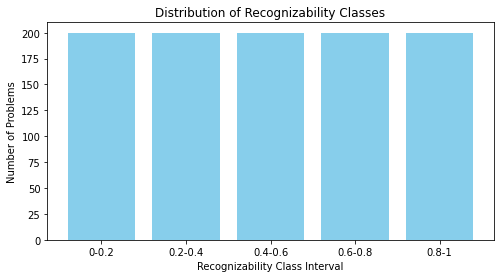

In [28]:
from collections import defaultdict

# First, deduplicate problems by name so that each problem (from the same plan) appears only once

problem_groups = defaultdict(list)
for problem in final_gr_problem_list_after_drop:
    problem_groups[problem.name].append(problem)

unique_problems = {name: random.choice(problems) for name, problems in problem_groups.items()}

# Group unique problems by recognizability class (using tuple of bounds as key)
problems_by_class = defaultdict(list)
for problem in unique_problems.values():
    rec_class_key = tuple(problem.recognizability_class)
    problems_by_class[rec_class_key].append(problem)

# Number of recognizability classes, assuming rec_classes defined in cell 1
num_classes = len(rec_classes)
desired_per_class = 1000 // num_classes

uniform_problems = []
for rec_class_key, problems in problems_by_class.items():
    if len(problems) >= desired_per_class:
        uniform_problems.extend(random.sample(problems, desired_per_class))
    else:
        uniform_problems.extend(problems)
        

print("Uniformly sampled problems (initial):", len(uniform_problems))

# If the total is less than 1000, fill with additional problems randomly from the remaining ones
if len(uniform_problems) < 1000:
    remaining = 1000 - len(uniform_problems)
    remaining_pool = [p for p in final_gr_problem_list_after_drop if p not in uniform_problems]
    if remaining_pool:
        extra = random.sample(remaining_pool, min(remaining, len(remaining_pool)))
        uniform_problems.extend(extra)
    print("After extra sampling, total problems:", len(uniform_problems))
    
    
import matplotlib.pyplot as plt

# Build a distribution dictionary with keys as "low-high" strings for each recognizability class
distribution = {f"{rc[0]}-{rc[1]}": 0 for rc in rec_classes}
for problem in uniform_problems:
    key = f"{problem.recognizability_class[0]}-{problem.recognizability_class[1]}"
    distribution[key] += 1

# Plot the distribution as a bar graph
plt.figure(figsize=(8, 4))
plt.bar(distribution.keys(), distribution.values(), color='skyblue')
plt.xlabel("Recognizability Class Interval")
plt.ylabel("Number of Problems")
plt.title("Distribution of Recognizability Classes")
plt.show()

In [ ]:
#to clear the results directory
for folder in os.listdir(results_dir):
    #remove directory if it exists along with its content
    if isdir(join(results_dir, folder)):
        shutil.rmtree(join(results_dir, folder))

In [26]:
test3 = True
count = 0


#write to file all the problems
for problem in uniform_problems:
    # print(problem)
    if test3:
        if count > 600:
            break
    write_original_plan(plan=problem.og_plan, goal_state=problem.base_goal_state, obj_set_dict=problem.objects)
    write_and_save_versions(
        plan=problem.og_plan,
        goal_state_list=problem.goal_state_list,
        obj_set_dict=problem.objects,
        rec_class=problem.recognizability_class,
    )
    count+=1

prendere lista di problemi, dove prendere circa 1000 problemi, divisi in modo uniforme tra le classi di recognizability 

ci aspettiamo 1000 piani nuovi + quelli originali quindi 1200, molto probabile alcuni non finiranno ma vedremo

prendere familiarità con i comandi per fare script per runnare i piani

create optimal plan è quello per runnare il planner 

run experiment per creare script a nastro, per poi runnare tot piani in parallelo, quindi non vogliamo un mega script

leggere articolo e vedere se c'è qualcosa che possiamo usare